In [1]:
import numpy as np
import math
import sys
# import myenv
sys.path.append('../src/features/')
sys.path.append('../src/data/')
import data_preprocessing_from_yahoo_finance as dp
import myenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from numba import cuda
from agent_a3c import Agent, Memory
import pandas as pd
tf.reset_default_graph()
sess = tf.InteractiveSession()

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
symbols = pd.read_csv('../data/raw/nasdaq100list.csv')['Symbol']
problem_ticker = ['QRTEA']
symbols = symbols[~symbols.isin(problem_ticker)]
s = list(symbols.sample(2))

In [3]:
# Create environment
result_np = dp.data_preprocessing_1(ticker_list_input=['PG','AAPL'], path='../data/raw/')
c = myenv.myenv(result_np)

# Create testing environment
testing_result_np =  dp.data_preprocessing_1(ticker_list_input=['HSBC'], path='../data/raw/')
c_testing = myenv.myenv(testing_result_np, initial_weight=[1/2,1/2])

working on PG
working on AAPL
working on HSBC


In [4]:
actor = Agent(no_of_stocks = 1, no_of_trading_days=2000,lr=0.05, scope='local', sess = sess, entropy_param = 0.3, clip=False)
global_net = Agent(no_of_stocks = 1, no_of_trading_days=2000,lr=0.05, scope='global', sess = sess, entropy_param = 0.3, clip=False)

In [5]:
actor_grads = tf.gradients(actor.actor_loss, actor.actor_params)
critic_grads = tf.gradients(actor.critic_loss, actor.critic_params)
actor_grads_clip = [tf.clip_by_value(grad, -1., 1.) for grad in actor_grads]
critic_grads_clip = [tf.clip_by_value(grad, -10., 10.) for grad in critic_grads]

In [6]:
train_actor = global_net.OPT_A.apply_gradients(zip(actor_grads_clip, global_net.actor_params))
train_critic = global_net.OPT_C.apply_gradients(zip(critic_grads_clip, global_net.critic_params))
pull_a_params_op = [tf.assign(actor_ap,global_ap) for actor_ap, global_ap in zip(actor.actor_params, global_net.actor_params)]
pull_c_params_op = [tf.assign(actor_cp, global_cp) for actor_cp, global_cp in zip(actor.critic_params, global_net.critic_params)]
# sess.run(train_actor)

Iter: 0
working on SYMC
Iter: 1
working on CTSH
Iter: 2
working on XEL
Iter: 3
working on BMRN
Iter: 4
working on XLNX
Iter: 5
working on ASML
Iter: 6
working on NTES
Iter: 7
working on CTSH
Iter: 8
working on FOXA
Iter: 9
working on MYL
Iter: 10
working on GOOGL
Iter: 11
working on NFLX
Iter: 12
working on BMRN
Iter: 13
working on MAR
Iter: 14
working on TXN
Iter: 15
working on CMCSA
Iter: 16
working on CMCSA
Iter: 17
working on ILMN
Iter: 18
working on TSLA
Iter: 19
working on LBTYK
Iter: 20
working on MELI
Iter: 21
working on MSFT
Iter: 22
working on QCOM
Iter: 23
working on BIDU
Iter: 24
working on BIDU
Iter: 25
working on WYNN
Iter: 26
working on WDAY
Iter: 27
working on ROST
Iter: 28
working on INCY
Iter: 29
working on QCOM
Iter: 30
working on AMZN
AMZN is not in raw data folder
The downloaded price data has shape(2518, 8)
AMZN's price data is saved.
Iter: 31
working on LRCX
Iter: 32
working on MNST
Iter: 33
working on VOD
Iter: 34
working on CTAS
Iter: 35
working on KHC
Iter: 36

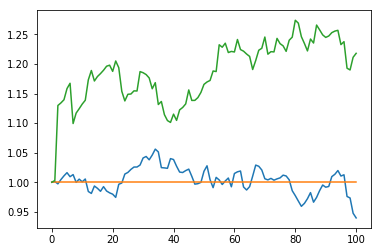

In [7]:
# Main Loop
# target_state_value = []
# for T in tqdm(range(3)):
for T in range(50):
    print('Iter:', T)
    s = list(symbols.sample(1))
    result_np = dp.data_preprocessing_1(ticker_list_input=s, path='../data/raw/')
    c = myenv.myenv(result_np, initial_weight=[1/2,1/2], reward_type='log_return')
    if c.all_prices.shape[1] < 2100: pass
    sess.run(tf.initializers.global_variables())
    price_tensor, weight,reward,done = c.reset()
    for i in (range(c.total_steps)):
        if price_tensor.shape[1] != 2000: break 
        action = sess.run(actor.new_weight, {actor.price_tensor:[price_tensor],
                                             actor.weight:[weight]})
        price_tensor, weight, reward, done = c.step(action[0])
        
        next_state_value = sess.run(global_net.state_value, {global_net.price_tensor:[price_tensor],
                                                             global_net.weight:[weight]})
#         print(reward)
        if done:
            target_state_value = np.array([reward])
        else:
            target_state_value = reward + 0.99*next_state_value[0]
        if i%1==0:
            sess.run(train_critic, {actor.price_tensor:[price_tensor], actor.weight:[weight],
                           actor.state_value_target:[target_state_value]})
            sess.run(train_actor, {actor.price_tensor:[price_tensor], actor.weight:[weight],
                            actor.state_value_target:[target_state_value]})
#         print(i, 'is done')
#         print(sess.run(global_net.critic_loss,{global_net.price_tensor:[price_tensor], global_net.weight:[weight],
#                                global_net.state_value_target:[target_state_value]}))
    sess.run([pull_a_params_op, pull_c_params_op])

c.end_game()
print('sharpe ratio:', c.sharpe_ratio)
p1,p2 = c.render_psize()
plt.show()

-0.05184979880977674


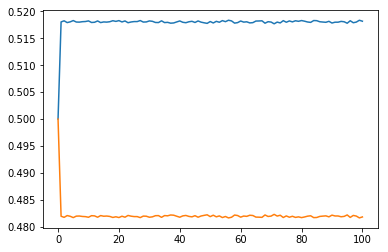

In [8]:
c.end_game()
print(c.sharpe_ratio)
c.render_weights(include_start=False)

In [9]:
c.all_prices.shape
c.total_steps
min(c.total_steps,c.all_prices_normalized.shape[1] - c.price_window)

100

In [10]:
actiona = sess.run(actor.new_weight, {actor.price_tensor:[price_tensor], actor.weight:[[0.5,0.5]]})
actiong = sess.run(global_net.new_weight, {global_net.price_tensor:[price_tensor], global_net.weight:[[0.5,0.5]]})
actiona[0] == actiong[0]
actiong[0]

array([0., 1.])

In [11]:
price_tensor.shape

(4, 2000, 2)

In [12]:
# target_state_value
next_state_value = sess.run(actor.state_value, {actor.price_tensor:[price_tensor], actor.weight:[weight]})
# 0.99*next_state_value[0]
next_state_value

array([[1.13855743e+08]])

In [13]:
# n = 2417
# price_tensor = c.all_prices_normalized[:,-n-100:-100,:]
# price_tensor.shape

In [14]:
action = sess.run(actor.new_weight, {actor.price_tensor:[price_tensor], actor.weight:[[1/2,1/2]]})
action[0]

array([0., 1.])

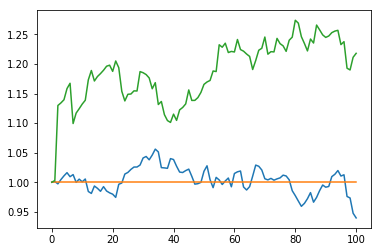

In [15]:
p1, p2 = c.render_psize()
plt.show()

In [16]:
next_state_value = sess.run(actor.state_value, {actor.price_tensor:[price_tensor], actor.weight:[weight]})
next_state_value

array([[1.13855743e+08]])

In [17]:
next_state_value = sess.run(global_net.state_value, {global_net.price_tensor:[price_tensor], global_net.weight:[weight]})
next_state_value

array([[1.13855743e+08]])

In [18]:
c_testing = myenv.myenv(testing_result_np, initial_weight=[1/2,1/2])
price_tensor, weight,_,done = c_testing.reset()
for i in tqdm(range(c_testing.total_steps)):
#     action = sess.run(global_net.new_weight, {global_net.price_tensor:[price_tensor], global_net.weight:[weight]})
    action = sess.run(actor.new_weight, {actor.price_tensor:[price_tensor], actor.weight:[weight]})
    price_tensor, weight, reward, done = c_testing.step(action[0])
    if done: break
c_testing.end_game()        

 98%|█████████▊| 98/100 [00:00<00:00, 190.11it/s]


-0.09560361200735545


([<matplotlib.lines.Line2D at 0x2422a67bbe0>],
  <matplotlib.lines.Line2D at 0x2422a6842b0>])

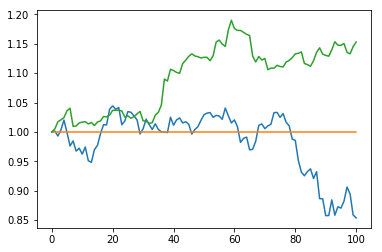

In [19]:
print(c_testing.sharpe_ratio)
c_testing.render_psize()

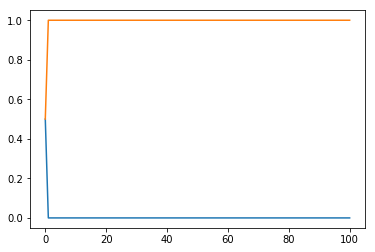

In [20]:
c_testing.render_weights(include_start=False)

working on WDAY


0it [00:00, ?it/s]
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([<matplotlib.lines.Line2D at 0x242312515c0>],
  <matplotlib.lines.Line2D at 0x24231251be0>])

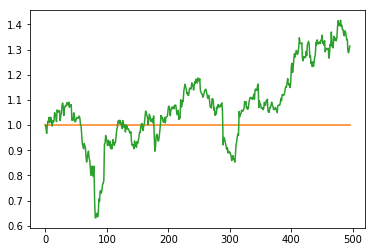

In [21]:
s = list(symbols.sample(1))
testing_result_np =  dp.data_preprocessing_1(ticker_list_input=s, path='../data/raw/')
c = myenv.myenv(testing_result_np, initial_weight=[1/2,1/2])
price_tensor, weight,_,done = c.reset()
for i in tqdm(range(c.total_steps)):
#     action = sess.run(global_net.new_weight, {global_net.price_tensor:[price_tensor], global_net.weight:[weight]})
    action = sess.run(actor.new_weight, {actor.price_tensor:[price_tensor], actor.weight:[weight]})
#     print(action)
    price_tensor, weight, reward, done = c.step(action[0])
    if done: break
c.end_game() 
c.render_psize()

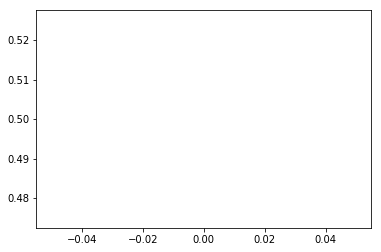

In [22]:
c.render_weights(include_start=False)